# Titanic - Machine Learning from Disaster

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='white', context='notebook', palette='muted')

import matplotlib.pyplot as plt

## Understanding the data

### Inspecting the data

First, let us check the training and test data sets.

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


The training set contains 891 samples, with a `Survived` label indicating whether the passenger has survived the shipwreck. The test set, with 418 sample, does not have this information, which needs to be learned from the training set.

The first few passengers information is shown in the following cell.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, let us combine the training and test data sets to see if there is any anomaly or missing value.

In [4]:
full = train.append(test, ignore_index=True)
full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


There are missing values for the `Age`, `Cabin`, `Embarked`, and `Fare` columns.

### Discovering correlations

#### Survival rate vs. embarking location

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

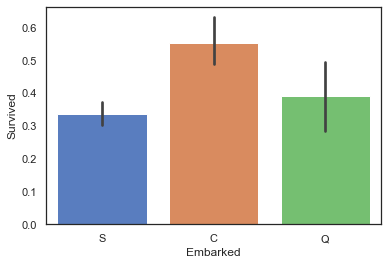

In [6]:
sns.barplot(data=train, x='Embarked', y='Survived')

In [7]:
print(full['Survived'][full['Embarked'] == 'S'].value_counts(normalize=True)[1])
print(full['Survived'][full['Embarked'] == 'C'].value_counts(normalize=True)[1])
print(full['Survived'][full['Embarked'] == 'Q'].value_counts(normalize=True)[1])

0.33695652173913043
0.5535714285714286
0.38961038961038963


From the above, we can see that passengers from Cherbourg, France are more likely to survive. It is probably due the fact that passengers from France are mainly first-class passengers. We can verify this observation.

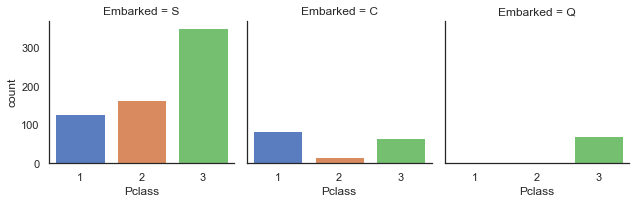

In [8]:
sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=3)

#### Survial rate vs. number of parents/children travelling together

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

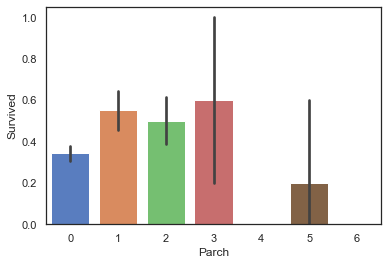

In [9]:
sns.barplot(data=train, x='Parch', y='Survived')

We can see that passengers travelling with family members between 1 and 3 are more likely to survive.

#### Survival rate vs. number of siblings travelling together

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

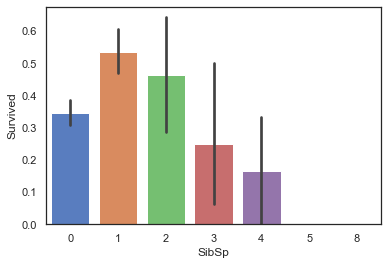

In [10]:
sns.barplot(data=train, x='SibSp', y='Survived')

#### Survival rate vs. fare class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

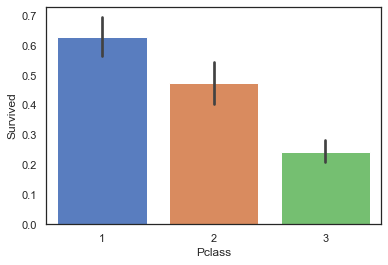

In [11]:
sns.barplot(data=train, x='Pclass', y='Survived')

Passengers with higher fare class are more likely to survive.


#### Survival rate vs. gender

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

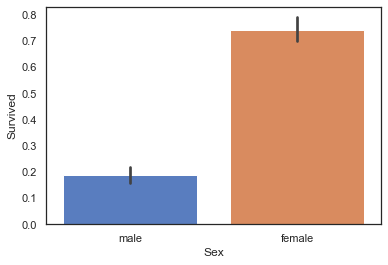

In [12]:
sns.barplot(data=train, x='Sex', y='Survived')

Female passenger are more likely to survive.

#### Survival rate vs. age

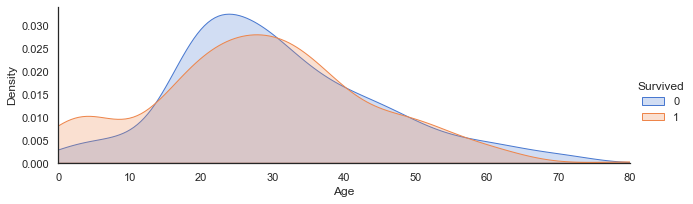

In [13]:
age = sns.FacetGrid(train, hue='Survived', aspect=3)
age.map(sns.kdeplot, 'Age', shade=True)
age.set(xlim=(0, train['Age'].max()))
age.add_legend()

Passengers with age between 0 and 10 are more likely to survive.

#### Survival rate vs. fare

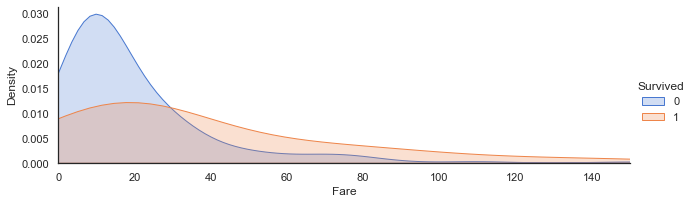

In [14]:
age = sns.FacetGrid(train, hue='Survived', aspect=3)
age.map(sns.kdeplot, 'Fare', shade=True)
age.set(xlim=(0, 150))
age.add_legend()

Passengers with higher fare are more likely to survive.

## Preprocessing the data

### Data cleansing

For missing data or anomalous value, we need to fill the value with some reasonable value.

#### Cabin

In [15]:
full['Cabin'] = full['Cabin'].fillna('U')
full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


#### Embarked

In [16]:
full[full['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


They are likely to depart from Southampton.

In [17]:
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [18]:
full['Embarked'] = full['Embarked'].fillna('S')

#### Fare

In [19]:
full[full['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,U,S


In [20]:
full['Fare'] = full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='S')&(full['Cabin']=='U')]['Fare'].mean())

Let us check the fare distribution.

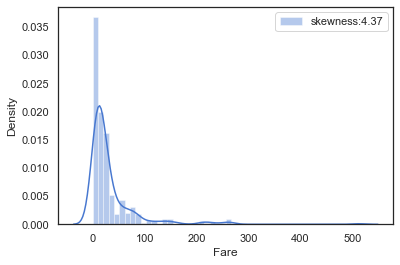

In [21]:
farePlot = sns.distplot(full['Fare'][full['Fare'].notnull()], label='skewness:%.2f'%(full['Fare'].skew()))
farePlot.legend(loc='best')

The fare distribution is highly skewed, and we need to take the logarithm of the fare.

In [22]:
full['Fare'] = full['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

### Feature engineering

#### Title

In [23]:
full['Title'] = full['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
full['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [24]:
title_dict = {}
title_dict['Mr'] = 'Mr'
title_dict['Mlle'] = 'Miss'
title_dict['Miss'] = 'Miss'
title_dict['Master'] = 'Master'
title_dict['Jonkheer'] = 'Master'
title_dict['Mme'] = 'Mrs'
title_dict['Ms'] = 'Mrs'
title_dict['Mrs'] = 'Mrs'
title_dict['Don'] = 'Royalty'
title_dict['Sir'] = 'Royalty'
title_dict['the Countess'] = 'Royalty'
title_dict['Dona'] = 'Royalty'
title_dict['Lady'] = 'Royalty'
title_dict['Capt'] = 'Officer'
title_dict['Col'] = 'Officer'
title_dict['Major'] = 'Officer'
title_dict['Dr'] = 'Officer'
title_dict['Rev'] = 'Officer'

full['Title'] = full['Title'].map(title_dict)
full['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

<AxesSubplot:xlabel='Title', ylabel='Survived'>

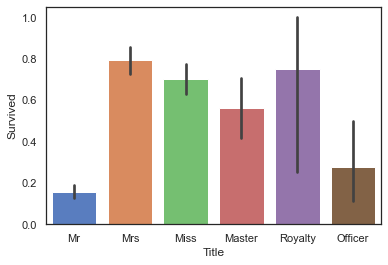

In [25]:
sns.barplot(data=full, x='Title', y='Survived')

#### Family Info

<AxesSubplot:xlabel='FamilyNumber', ylabel='Survived'>

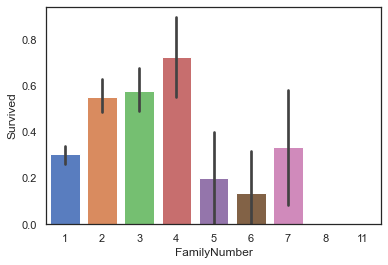

In [26]:
full['FamilyNumber'] = full['Parch'] + full['SibSp'] + 1
sns.barplot(data=full, x='FamilyNumber', y='Survived')

In [27]:
def family_size(family_number):
  if family_number == 1:
    return 0
  elif family_number >= 2 and family_number <= 4:
    return 1
  else:
    return 2

full['FamilySize'] = full['FamilyNumber'].map(family_size)
full['FamilySize'].value_counts()

0    790
1    437
2     82
Name: FamilySize, dtype: int64

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

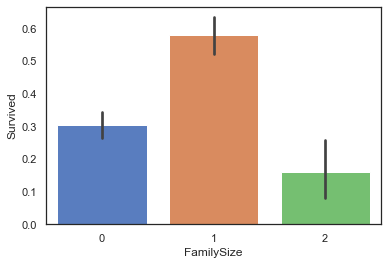

In [28]:
sns.barplot(data=full, x='FamilySize', y='Survived')

#### Deck Info

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

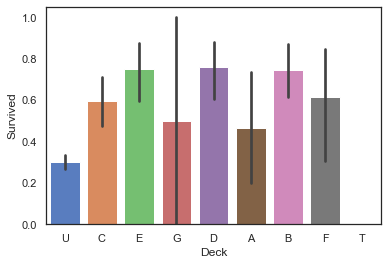

In [29]:
full['Deck'] = full['Cabin'].map(lambda x: x[0])
sns.barplot(data=full, x='Deck', y='Survived')

#### Ticket Info

In [34]:
ticket_dict = {}
ticket_dict = full['Ticket'].value_counts()
ticket_dict.head()

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
Name: Ticket, dtype: int64

In [42]:
full['TicketNumber'] = full['Ticket'].map(ticket_dict)
full['TicketNumber'].describe()

count    1309.000000
mean        2.101604
std         1.779832
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        11.000000
Name: TicketNumber, dtype: float64

<AxesSubplot:xlabel='TicketNumber', ylabel='Survived'>

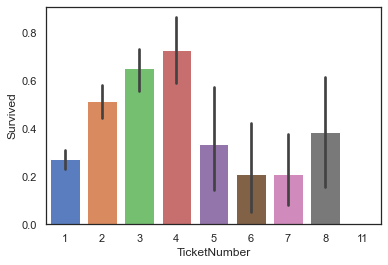

In [36]:
sns.barplot(data=full, x='TicketNumber', y='Survived')

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

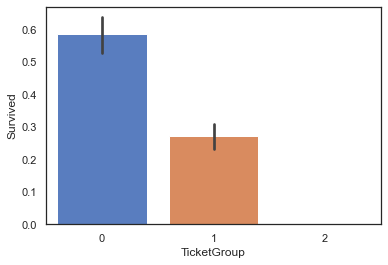

In [37]:
def ticket_group(ticket_number):
  if ticket_number >= 2 and ticket_number <= 4:
    return 0
  elif ticket_number == 1 or (ticket_number >= 5 and ticket_number <= 8):
    return 1
  else:
    return 2

full['TicketGroup'] = full['TicketNumber'].map(ticket_group)
sns.barplot(data=full, x='TicketGroup', y='Survived')

#### Age

In [38]:
full[full['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilyNumber,FamilySize,Deck,TicketNumber,TicketGroup
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,2.135148,U,Q,Mr,1,0,U,1,1
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,2.564949,U,S,Mr,1,0,U,1,1
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,1.977547,U,C,Mrs,1,0,U,1,1
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,1.977547,U,C,Mr,1,0,U,1,1
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,2.064226,U,Q,Miss,1,0,U,1,1


In [40]:
age_pre = full[['Age', 'Parch', 'Pclass', 'SibSp', 'Title', 'FamilyNumber', 'TicketNumber']]
age_pre.head()

,Age,Parch,Pclass,SibSp,Title,FamilyNumber,TicketNumber
0,22.0,0,3,1,Mr,2,1
1,38.0,0,1,1,Mrs,2,2
2,26.0,0,3,0,Miss,1,1
3,35.0,0,1,1,Mrs,2,2
4,35.0,0,3,0,Mr,1,1


In [41]:
age_pre = pd.get_dummies(age_pre)
age_pre.head()

,Age,Parch,Pclass,SibSp,FamilyNumber,TicketNumber,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,3,1,2,1,0,0,1,0,0,0
1,38.0,0,1,1,2,2,0,0,0,1,0,0
2,26.0,0,3,0,1,1,0,1,0,0,0,0
3,35.0,0,1,1,2,2,0,0,0,1,0,0
4,35.0,0,3,0,1,1,0,0,1,0,0,0


In [44]:
par_age = pd.get_dummies(age_pre['Parch'], prefix='Parch')
sib_age = pd.get_dummies(age_pre['SibSp'], prefix='Sibsp')
pcl_age = pd.get_dummies(age_pre['Pclass'], prefix='Pclass')

In [45]:
corr = pd.DataFrame()
corr = age_pre.corr()
corr['Age'].sort_values()

Pclass          -0.408106
Title_Master    -0.385380
Title_Miss      -0.282977
SibSp           -0.243699
FamilyNumber    -0.240229
TicketNumber    -0.185284
Parch           -0.150917
Title_Royalty    0.057337
Title_Officer    0.166771
Title_Mr         0.183965
Title_Mrs        0.215091
Age              1.000000
Name: Age, dtype: float64

In [49]:
age_pre = pd.concat([age_pre, par_age, sib_age, pcl_age], axis=1)
age_pre.head(10)

,Age,Parch,Pclass,SibSp,FamilyNumber,TicketNumber,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Sibsp_0,Sibsp_1,Sibsp_2,Sibsp_3,Sibsp_4,Sibsp_5,Sibsp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
5,NaN,0,3,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
6,54.0,0,1,0,1,2,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
7,2.0,1,3,3,5,5,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
8,27.0,2,3,0,3,3,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
9,14.0,0,2,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [50]:
age_train = age_pre[age_pre['Age'].notnull()]
age_test = age_pre[age_pre['Age'].isnull()]

age_train_X = age_train.drop(['Age'], axis=1)
age_train_y = age_train['Age']

age_test_X = age_test.drop(['Age'], axis=1)

In [51]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1)
rf_reg.fit(age_train_X, age_train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [52]:
rf_reg.score(age_train_X, age_train_y)

0.5876015705643867

In [54]:
age_test_y = rf_reg.predict(age_test_X)
full.loc[full['Age'].isnull(), ['Age']] = age_test_y
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Survived      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Name          1309 non-null   object 
 4   Sex           1309 non-null   object 
 5   Age           1309 non-null   float64
 6   SibSp         1309 non-null   int64  
 7   Parch         1309 non-null   int64  
 8   Ticket        1309 non-null   object 
 9   Fare          1309 non-null   float64
 10  Cabin         1309 non-null   object 
 11  Embarked      1309 non-null   object 
 12  Title         1309 non-null   object 
 13  FamilyNumber  1309 non-null   int64  
 14  FamilySize    1309 non-null   int64  
 15  Deck          1309 non-null   object 
 16  TicketNumber  1309 non-null   int64  
 17  TicketGroup   1309 non-null   int64  
dtypes: float64(3), int64(8), obj

#### Last name

### Subset selection

In [55]:
transformed = full.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)

corr = pd.DataFrame()
corr = transformed.corr()
corr['Survived'].sort_values(ascending=True)

Pclass         -0.338481
TicketGroup    -0.319278
Age            -0.059252
SibSp          -0.035322
FamilyNumber    0.016639
TicketNumber    0.064962
Parch           0.081629
FamilySize      0.108631
Fare            0.331805
Survived        1.000000
Name: Survived, dtype: float64

In [58]:
transformed = transformed.drop(['FamilyNumber', 'SibSp', 'TicketNumber', 'Parch'], axis=1)
transformed.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,Deck,TicketGroup
0,0.0,3,male,22.0,1.981001,S,Mr,1,U,1
1,1.0,1,female,38.0,4.266662,C,Mrs,1,C,0
2,1.0,3,female,26.0,2.070022,S,Miss,0,U,1
3,1.0,1,female,35.0,3.972177,S,Mrs,1,C,0
4,0.0,3,male,35.0,2.085672,S,Mr,0,U,1


In [61]:
transformed = pd.get_dummies(transformed)
pclass_df = pd.get_dummies(full['Pclass'], prefix='Pclass')
ticket_group_df = pd.get_dummies(full['TicketGroup'], prefix='TicketGroup')
family_size_df = pd.get_dummies(full['FamilySize'], prefix='FamilySize')

transformed = pd.concat([transformed, pclass_df, ticket_group_df, family_size_df], axis=1)
transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   int64  
 2   Age            1309 non-null   float64
 3   Fare           1309 non-null   float64
 4   FamilySize     1309 non-null   int64  
 5   TicketGroup    1309 non-null   int64  
 6   Sex_female     1309 non-null   uint8  
 7   Sex_male       1309 non-null   uint8  
 8   Embarked_C     1309 non-null   uint8  
 9   Embarked_Q     1309 non-null   uint8  
 10  Embarked_S     1309 non-null   uint8  
 11  Title_Master   1309 non-null   uint8  
 12  Title_Miss     1309 non-null   uint8  
 13  Title_Mr       1309 non-null   uint8  
 14  Title_Mrs      1309 non-null   uint8  
 15  Title_Officer  1309 non-null   uint8  
 16  Title_Royalty  1309 non-null   uint8  
 17  Deck_A         1309 non-null   uint8  
 18  Deck_B  

## Modeling

In [62]:
train_data = transformed[transformed['Survived'].notnull()]
test_data = transformed[transformed['Survived'].isnull()]

train_data_X = train_data.drop(['Survived'], axis=1)
train_data_y = train_data['Survived']

test_data_X = test_data.drop(['Survived'], axis=1)

In [64]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [65]:
k_fold = StratifiedKFold(n_splits=10)

classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(AdaBoostClassifier())
classifiers.append(HistGradientBoostingClassifier())
classifiers.append(XGBClassifier())

In [66]:
cv_results = []
for clf in classifiers:
  cv_results.append(cross_val_score(clf, train_data_X, train_data_y, scoring='accuracy', cv=k_fold, n_jobs=-1))

In [67]:
cv_means = []
cv_deviations = []
for result in cv_results:
  cv_means.append(result.mean())
  cv_deviations.append(result.std())

results = pd.DataFrame({'cv_mean': cv_means,
                        'cv_std': cv_deviations,
                        'algorithm': ['SVC', 'DecisionTree', 'RandomForest', 'ExtraTree', 'GBDT',
                                      'KNN', 'LR', 'LDA', 'AdaBoost', 'LightGBM', 'XGBoost']})
results

,cv_mean,cv_std,algorithm
0,0.762172,0.051223,SVC
1,0.782347,0.063228,DecisionTree
2,0.812647,0.041274,RandomForest
3,0.801398,0.046061,ExtraTree
4,0.833933,0.034514,GBDT
5,0.793533,0.038052,KNN
6,0.829438,0.030671,LR
7,0.823833,0.029460,LDA
8,0.817116,0.022459,AdaBoost
9,0.823845,0.046630,LightGBM
